In [2]:
import numpy as np
from datetime import datetime, timedelta
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

In [3]:
data = np.genfromtxt("data.csv", delimiter=",", dtype=None, encoding="UTF-8")

# Define classes and helper functions

In [4]:
class Voter:
    def __init__(self, canidates, dt, normal, ranks):
        self.candidates = canidates
        self.dt = dt
        self.normal = normal
        self.voting_list = []
        for i in range(1, len(ranks)+1):
            try:
                j = ranks.index(i)
                self.voting_list += [candidates[j]]
            except ValueError:
                pass
    
    def vote(self, rejects=[]):
        for el in self.voting_list:
            if el not in rejects:
                return el
        return self.candidates[-1]
    
    def __getitem__(self, i):
        return self.voting_list[i]
    
    def __len__(self):
        return len(self.voting_list)

        
class Candidate:
    def __init__(self, i, name, colour):
        self.i = i
        self.name = name
        self.c = colour
    
    @property
    def s(self):
        return self.name.split(" ")[0]
    
    def __repr__(self):
        return "Candidate({}, {})".format(self.i, self.name)
    
    def __str__(self):
        return self.name
    
def summary(candidates, votes):
    for candidate in candidates:
        print(candidate, votes.count(candidate))
        
def get_candidate(search):
    for candidate in candidates:
        if search in candidate.name:
            return candidate

# Define colours for all candidates

<IPython.core.display.Javascript object>


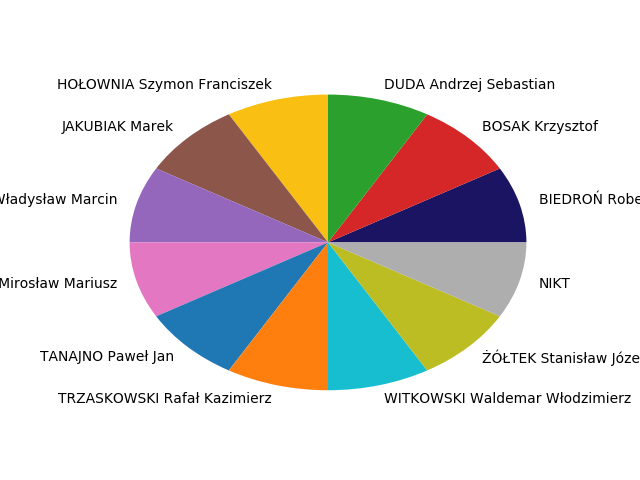

In [5]:
tab = ['#1b1462', '#d62728', '#2ca02c', '#f9c013', '#8c564b', '#9467bd', '#e377c2', '#1f77b4', '#ff7f0e', '#17becf', '#bcbd22', "#aeaeae"]
fig, ax = plt.subplots()
ax.pie([1]*(len(data[0])-1), labels=[x[51:-1] for x in data[0][1:-1]] + ["NIKT"], colors=tab)
plt.show()

# Generate lists of candidates and voters

In [6]:
candidates = []
for i, el in enumerate(data[0][1:-1]):
    candidates += [Candidate(i+1, el[51:-1], tab[i])]
none_cand = Candidate(0, "NIKT Nikt", tab[-1])
candidates += [none_cand]
print(candidates)

[Candidate(1, BIEDROŃ Robert), Candidate(2, BOSAK Krzysztof), Candidate(3, DUDA Andrzej Sebastian), Candidate(4, HOŁOWNIA Szymon Franciszek), Candidate(5, JAKUBIAK Marek), Candidate(6, KOSINIAK-KAMYSZ Władysław Marcin), Candidate(7, PIOTROWSKI Mirosław Mariusz), Candidate(8, TANAJNO Paweł Jan), Candidate(9, TRZASKOWSKI Rafał Kazimierz), Candidate(10, WITKOWSKI Waldemar Włodzimierz), Candidate(11, ŻÓŁTEK Stanisław Józef), Candidate(0, NIKT Nikt)]


In [7]:
voters = []
for row in data[1:]:
    dt = datetime.strptime(row[0], "%d/%m/%Y %H:%M:%S")
    try:
        normal = [x for x in candidates if x.name == row[-1]][0]
    except IndexError:
        normal = none_cand
    ranks = [int(x) if x!="" else None for x in row[1:-1]]
    voters += [Voter(candidates, dt, normal, ranks)]

# The voting process laid out
This is mostly for illustrating the code behind the process, we make a graph in the next section

In [8]:
rejects = []
total = len(voters)
for k in range(15):
    print("-"*25)
    
    # Make all the voters vote
    votes = [x.vote(rejects) for x in voters]
    # Count votes for each candidate
    nvotes = [votes.count(candidate) for candidate in candidates]
    
    # Show how many votes people got in this round
    summary(candidates, votes)
    
    # Check if anyone's won
    if np.amax(nvotes)/total > 0.5:
        winner = candidates[np.argmax(nvotes)]
        print("The winner is {} with {:.2f}% of the vote".format(winner, np.amax(nvotes)/total*100))
        # Stop the election once a winner chosen
        break
    else:
        # Find the person with the least votes that isn't none_cand
        reject = None
        minv = np.inf
        for i in range(len(nvotes)):
            if nvotes[i] < minv and candidates[i] not in rejects and candidates[i] is not none_cand:
                reject = candidates[i]
                minv = nvotes[i]
        rejects += [reject]
        print("We reject {} with {:.2f}% of the vote".format(reject, minv/total*100))

-------------------------
BIEDROŃ Robert 73
BOSAK Krzysztof 21
DUDA Andrzej Sebastian 3
HOŁOWNIA Szymon Franciszek 45
JAKUBIAK Marek 0
KOSINIAK-KAMYSZ Władysław Marcin 6
PIOTROWSKI Mirosław Mariusz 1
TANAJNO Paweł Jan 0
TRZASKOWSKI Rafał Kazimierz 70
WITKOWSKI Waldemar Włodzimierz 20
ŻÓŁTEK Stanisław Józef 7
NIKT Nikt 7
We reject JAKUBIAK Marek with 0.00% of the vote
-------------------------
BIEDROŃ Robert 73
BOSAK Krzysztof 21
DUDA Andrzej Sebastian 3
HOŁOWNIA Szymon Franciszek 45
JAKUBIAK Marek 0
KOSINIAK-KAMYSZ Władysław Marcin 6
PIOTROWSKI Mirosław Mariusz 1
TANAJNO Paweł Jan 0
TRZASKOWSKI Rafał Kazimierz 70
WITKOWSKI Waldemar Włodzimierz 20
ŻÓŁTEK Stanisław Józef 7
NIKT Nikt 7
We reject TANAJNO Paweł Jan with 0.00% of the vote
-------------------------
BIEDROŃ Robert 73
BOSAK Krzysztof 21
DUDA Andrzej Sebastian 3
HOŁOWNIA Szymon Franciszek 45
JAKUBIAK Marek 0
KOSINIAK-KAMYSZ Władysław Marcin 6
PIOTROWSKI Mirosław Mariusz 1
TANAJNO Paweł Jan 0
TRZASKOWSKI Rafał Kazimierz 70
WITKOW

# Make a sankey (flow) graph of the election
This generates text that needs to be pasted into http://sankeymatic.com/build/

In [9]:
# http://sankeymatic.com/build/
rejects = []
total = len(voters)
# Use the candidate's surname for display
fmt = lambda x: x.s

for r in range(11):
    # Nothing interesting happens initially (candidates with no votes are rejected)
    # so we offset the 'beginning' of the graph (here r is the round number).
    r = r-1
    # If a candidate has not been rejected, they get their votes from the previous round
    if r+1:
        for i in range(len(candidates)):
            if nvotes[i] and candidates[i] not in rejects:
                print("{}. {} [{}] {}. {} {}.1".format(r-1, fmt(candidates[i]), nvotes[i], r, fmt(candidates[i]), candidates[i].c))
    
    # Colour the candidate nodes correctly
    for candidate in candidates:
        if candidate not in rejects:
            print(":{}. {} {}".format(r, fmt(candidate), candidate.c))
    
    # Count the votes
    votes = [x.vote(rejects) for x in voters]
    nvotes = [votes.count(candidate) for candidate in candidates]
        
    # Has anyone won?    
    if np.amax(nvotes)/total > 0.5:
        print(":{}. NIKT #aeaeae".format(r))
        pass
    else:
        # Find the reject
        reject = None
        minv = np.inf
        for i in range(len(nvotes)):
            if nvotes[i] < minv and candidates[i] not in rejects and candidates[i] is not none_cand:
                reject = candidates[i]
                minv = nvotes[i]
        
        # Find the voters voting for the rejected candidate
        voters_rejected = [x for x in voters if x.vote(rejects) == reject]
        rejects += [reject]
        # Count the new votes of the rejected voters
        rvotes = [x.vote(rejects) for x in voters_rejected]
        rnvotes = [rvotes.count(candidate) for candidate in candidates]
        # Add the corresponding flows to the sankey
        for i in range(len(candidates)):
            if rnvotes[i]:
                print("{}. {} [{}] {}. {}".format(r, fmt(reject), rnvotes[i], r+1, fmt(candidates[i])))

:-1. BIEDROŃ #1b1462
:-1. BOSAK #d62728
:-1. DUDA #2ca02c
:-1. HOŁOWNIA #f9c013
:-1. JAKUBIAK #8c564b
:-1. KOSINIAK-KAMYSZ #9467bd
:-1. PIOTROWSKI #e377c2
:-1. TANAJNO #1f77b4
:-1. TRZASKOWSKI #ff7f0e
:-1. WITKOWSKI #17becf
:-1. ŻÓŁTEK #bcbd22
:-1. NIKT #aeaeae
-1. BIEDROŃ [73] 0. BIEDROŃ #1b1462.1
-1. BOSAK [21] 0. BOSAK #d62728.1
-1. DUDA [3] 0. DUDA #2ca02c.1
-1. HOŁOWNIA [45] 0. HOŁOWNIA #f9c013.1
-1. KOSINIAK-KAMYSZ [6] 0. KOSINIAK-KAMYSZ #9467bd.1
-1. PIOTROWSKI [1] 0. PIOTROWSKI #e377c2.1
-1. TRZASKOWSKI [70] 0. TRZASKOWSKI #ff7f0e.1
-1. WITKOWSKI [20] 0. WITKOWSKI #17becf.1
-1. ŻÓŁTEK [7] 0. ŻÓŁTEK #bcbd22.1
-1. NIKT [7] 0. NIKT #aeaeae.1
:0. BIEDROŃ #1b1462
:0. BOSAK #d62728
:0. DUDA #2ca02c
:0. HOŁOWNIA #f9c013
:0. KOSINIAK-KAMYSZ #9467bd
:0. PIOTROWSKI #e377c2
:0. TANAJNO #1f77b4
:0. TRZASKOWSKI #ff7f0e
:0. WITKOWSKI #17becf
:0. ŻÓŁTEK #bcbd22
:0. NIKT #aeaeae
0. BIEDROŃ [73] 1. BIEDROŃ #1b1462.1
0. BOSAK [21] 1. BOSAK #d62728.1
0. DUDA [3] 1. DUDA #2ca02c.1
0. HOŁOWNIA [45]

# First preference vs second preference

<IPython.core.display.Javascript object>


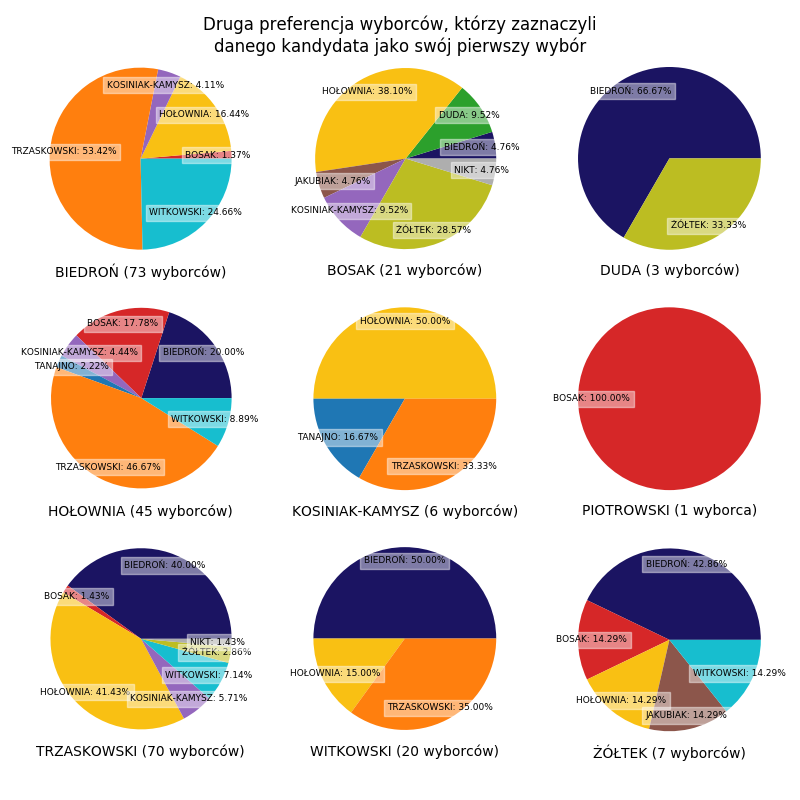

In [33]:
votes = [x.vote() for x in voters]
# Get a list of candidates who got at least one vote as a first preference
firsts = [x for x in candidates if votes.count(x)][:-1]

# Make a 3x3 graph
fig, ax = plt.subplots(3, 3, figsize=(8,8))
ax = ax.flatten()

for i, candidate in enumerate(firsts):
    # Get second choices of people who woted for this candidate
    seconds = [x.vote([candidate]) for x in [y for y in voters if y.vote() == candidate]]
#     ax[i].pie([seconds.count(x) for x in candidates if seconds.count(x)], labels=[x.s for x in candidates if seconds.count(x)],
#               autopct='%1.1f%%', colors=[x.c for x in candidates if seconds.count(x)], pctdistance=0.8,
#               textprops={"backgroundcolor":"#ffffff50", "fontsize":6})
    labels = ["{}: {:.2f}%".format(x.s, seconds.count(x)/votes.count(candidate)*100) for x in candidates if seconds.count(x)]
    patches, texts = ax[i].pie([seconds.count(x) for x in candidates if seconds.count(x)], labels=labels, labeldistance=0.85,
              colors=[x.c for x in candidates if seconds.count(x)],
              textprops={"backgroundcolor":"#ffffff70"})
    for text in texts:
        text.set_fontsize(6.5)
        text.set_horizontalalignment("center")
    ax[i].set_xlabel("{} ({} wyborc{})".format(candidate.s, votes.count(candidate), 'a' if votes.count(candidate)==1 else "ów"))
    ax[i].axis('equal')

fig.suptitle("Druga preferencja wyborców, którzy zaznaczyli\ndanego kandydata jako swój pierwszy wybór")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("img/second_pref.svg", bbox_inches="tight")
plt.show()

# Standard voting vs first preference

<IPython.core.display.Javascript object>


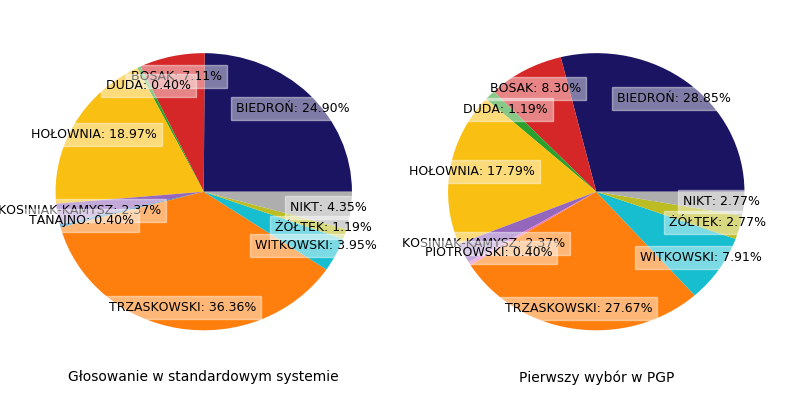

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Preferences in normal elections
normals = [x.normal for x in voters]

labels = ["{}: {:.2f}%".format(x.s, normals.count(x)/len(voters)*100) for x in candidates if normals.count(x)]
patches, texts = ax[0].pie([normals.count(x) for x in candidates if normals.count(x)], labels=labels, labeldistance=0.85,
          colors=[x.c for x in candidates if normals.count(x)],
          textprops={"backgroundcolor":"#ffffff70"})
for text in texts:
    text.set_fontsize(9)
    text.set_horizontalalignment("center")
ax[0].set_xlabel("Głosowanie w standardowym systemie")

# First preference, excuse the misc variable name
normals = [x.vote() for x in voters]

labels = ["{}: {:.2f}%".format(x.s, normals.count(x)/len(voters)*100) for x in candidates if normals.count(x)]
patches, texts = ax[1].pie([normals.count(x) for x in candidates if normals.count(x)], labels=labels, labeldistance=0.85,
          colors=[x.c for x in candidates if normals.count(x)],
          textprops={"backgroundcolor":"#ffffff70"})
for text in texts:
    text.set_fontsize(9)
    text.set_horizontalalignment("center")
ax[1].set_xlabel("Pierwszy wybór w PGP")

plt.tight_layout()

plt.savefig("img/normal_vs_pgp.svg", bbox_inches="tight")
plt.show()

# First preference of people who would vote for a given candidate in normal elections

<IPython.core.display.Javascript object>


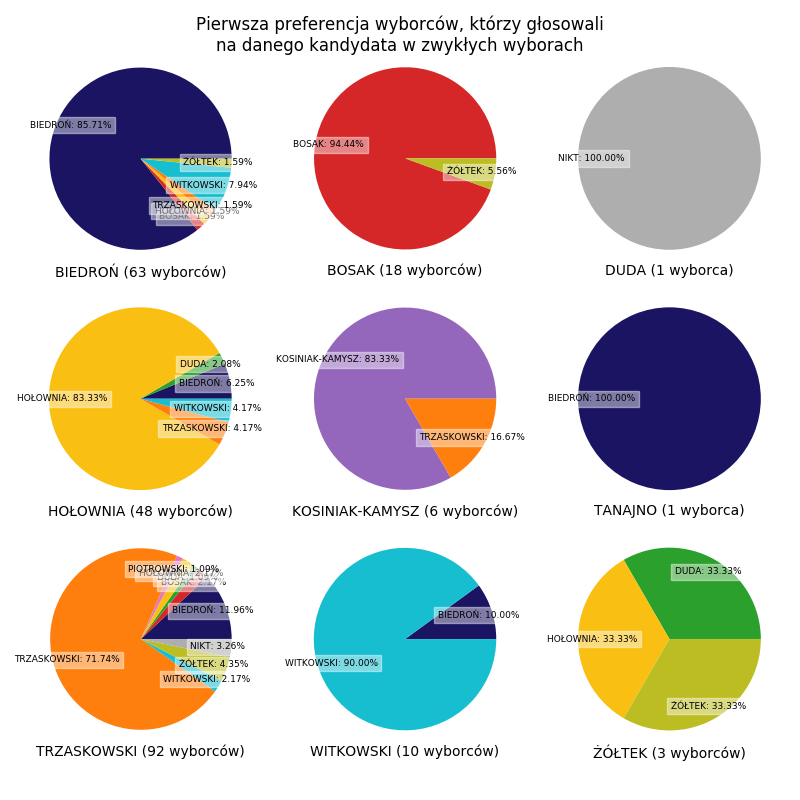

In [29]:
# Get a list of candidates who got at least one vote in the normal election
normals = [x.normal for x in voters]
norm_cands = [x for x in candidates if x in normals][:-1]

fig, ax = plt.subplots(3, 3, figsize=(8,8))
ax = ax.flatten()

for i, candidate in enumerate(norm_cands):
    # Get the first preference of voters who voted for this candidate in the normal election
    firsts = [x.vote() for x in [y for y in voters if y.normal == candidate]]
    labels = ["{}: {:.2f}%".format(x.s, firsts.count(x)/len(firsts)*100) for x in candidates if firsts.count(x)]
    patches, texts = ax[i].pie([firsts.count(x) for x in candidates if firsts.count(x)], labels=labels, labeldistance=0.85,
              colors=[x.c for x in candidates if firsts.count(x)],
              textprops={"backgroundcolor":"#ffffff70"})
    for text in texts:
        text.set_fontsize(6.5)
        text.set_horizontalalignment("center")
    ax[i].set_xlabel("{} ({} wyborc{})".format(candidate.s, len(firsts), 'a' if len(firsts)==1 else "ów"))
    ax[i].axis('equal')
    
fig.suptitle("Pierwsza preferencja wyborców, którzy głosowali\nna danego kandydata w zwykłych wyborach")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("img/first_pref_vs_normal.svg", bbox_inches="tight")
plt.show()

# Preference stats per candidate

<IPython.core.display.Javascript object>


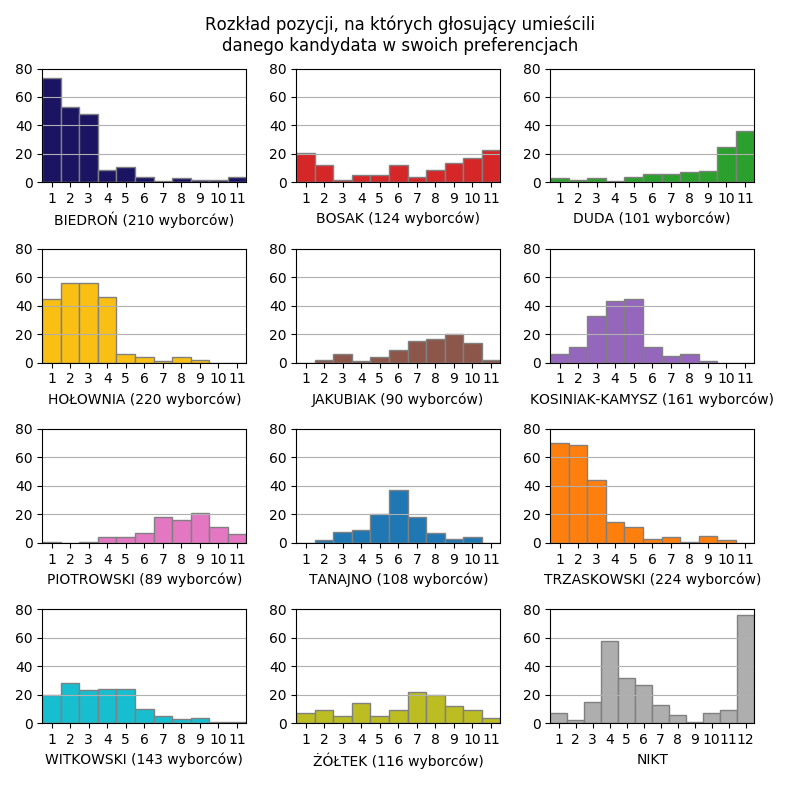

In [32]:
fig, ax = plt.subplots(4,3, figsize=(8,8))
ax = ax.flatten()
bins = np.linspace(.5, 11.5, 12)

for i, candidate in enumerate(candidates[:-1]):
    # pos is a list of positions this candidate was put on by the voters
    pos = [voter.voting_list.index(candidate)+1 for voter in voters if candidate in voter.voting_list]
    ax[i].hist(pos, bins=bins, color=candidate.c, linewidth=1, edgecolor='grey')
    ax[i].xaxis.set_major_locator(MultipleLocator(1))
    ax[i].set_xlabel("{} ({} wyborców)".format(candidate.s, len(pos)))
    ax[i].set_xlim(0.5,11.5)
    ax[i].set_ylim(0,80)
    ax[i].grid(axis='y')

# Add a histogram showing when people stopped numbering
ax[-1].hist([len(x.voting_list)+1 for x in voters], bins=np.linspace(.5, 12.5, 13), color=candidates[-1].c, linewidth=1, edgecolor='grey')
ax[-1].xaxis.set_major_locator(MultipleLocator(1))
ax[-1].set_xlabel("NIKT")
ax[-1].set_xlim(0.5,12.5)
ax[-1].set_ylim(0,80)
ax[-1].grid(axis='y')

fig.suptitle("Rozkład pozycji, na których głosujący umieścili\ndanego kandydata w swoich preferencjach")
plt.tight_layout(rect=[0, 0.02, 1, 0.94])

plt.savefig("img/pos_hist.svg", bbox_inches="tight")
plt.show()

# Histogram of questionaire answers over time

<IPython.core.display.Javascript object>


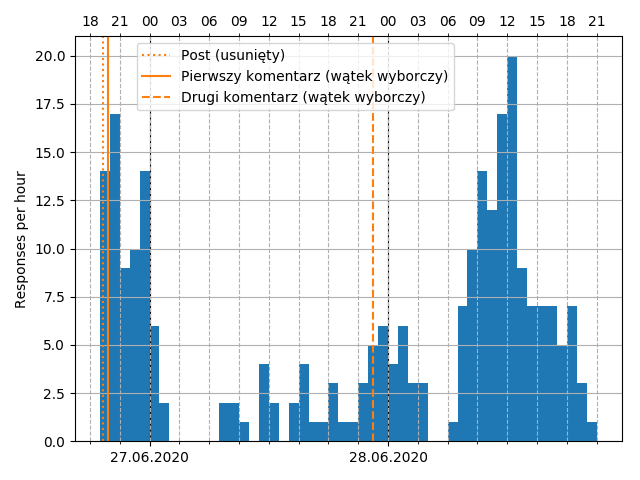

In [30]:
fig, ax = plt.subplots()
start = datetime(2020,6,26,19)

# Plot histogram
ax.hist(mdates.date2num([x.dt for x in voters]), bins=mdates.date2num([start+i*timedelta(hours=1) for i in range(51)]))

# Add times of posts/comments
ax.plot(mdates.date2num([datetime(2020,6,26,19,19,20), datetime(2020,6,26,19,19,20)]),
        [0,25], ":", c="tab:orange", label="Post (usunięty)")
ax.plot(mdates.date2num([datetime(2020,6,26,19,49,55), datetime(2020,6,26,19,49,55)]),
        [0,25], "-", c="tab:orange", label="Pierwszy komentarz (wątek wyborczy)")
ax.plot(mdates.date2num([datetime(2020,6,27,22,27,28), datetime(2020,6,27,22,27,28)]),
        [0,25], "--", c="tab:orange", label="Drugi komentarz (wątek wyborczy)")
ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0, 1, 1))

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0,24,3)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax.grid(which='minor', ls="--")
ax.grid(which='major', axis='x', ls="-", c='black')
ax.grid(which='major', axis='y')
ax.tick_params(which="minor", top=True, labeltop=True, labelbottom=False)
ax.set_ylabel("Responses per hour")
ax.set_ylim(0,21)

plt.tight_layout()

plt.savefig("img/time_hist.svg", bbox_inches="tight")
plt.show()